In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

## Data Loading and Preparation

In [37]:
df = pd.read_csv('Breast_cancer_dataset.csv')

In [38]:
# Drop unnecessary columns
df = df.drop(columns=['id', 'Unnamed: 32'], errors='ignore')

In [39]:
# Encode 'diagnosis' (M=0, B=1) for the models
df['diagnosis'] = df['diagnosis'].map({'M': 0, 'B': 1})

In [40]:
# Split the data into features (X) and target (y)
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

## EDA

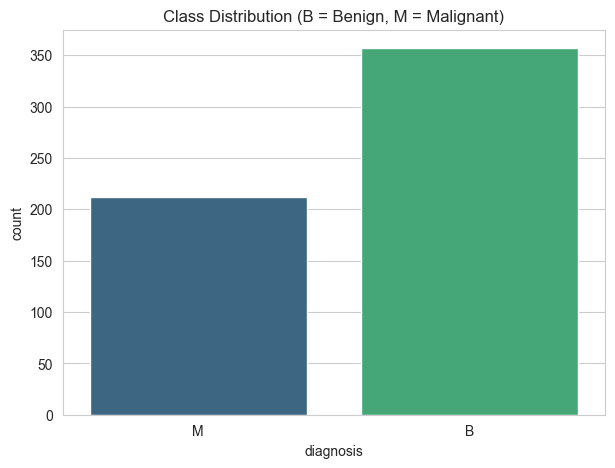

In [41]:
plt.figure(figsize=(7, 5))
sns.countplot(x='diagnosis', data=df_viz, hue='diagnosis', palette='viridis', legend=False)
plt.title('Class Distribution (B = Benign, M = Malignant)')
plt.show()

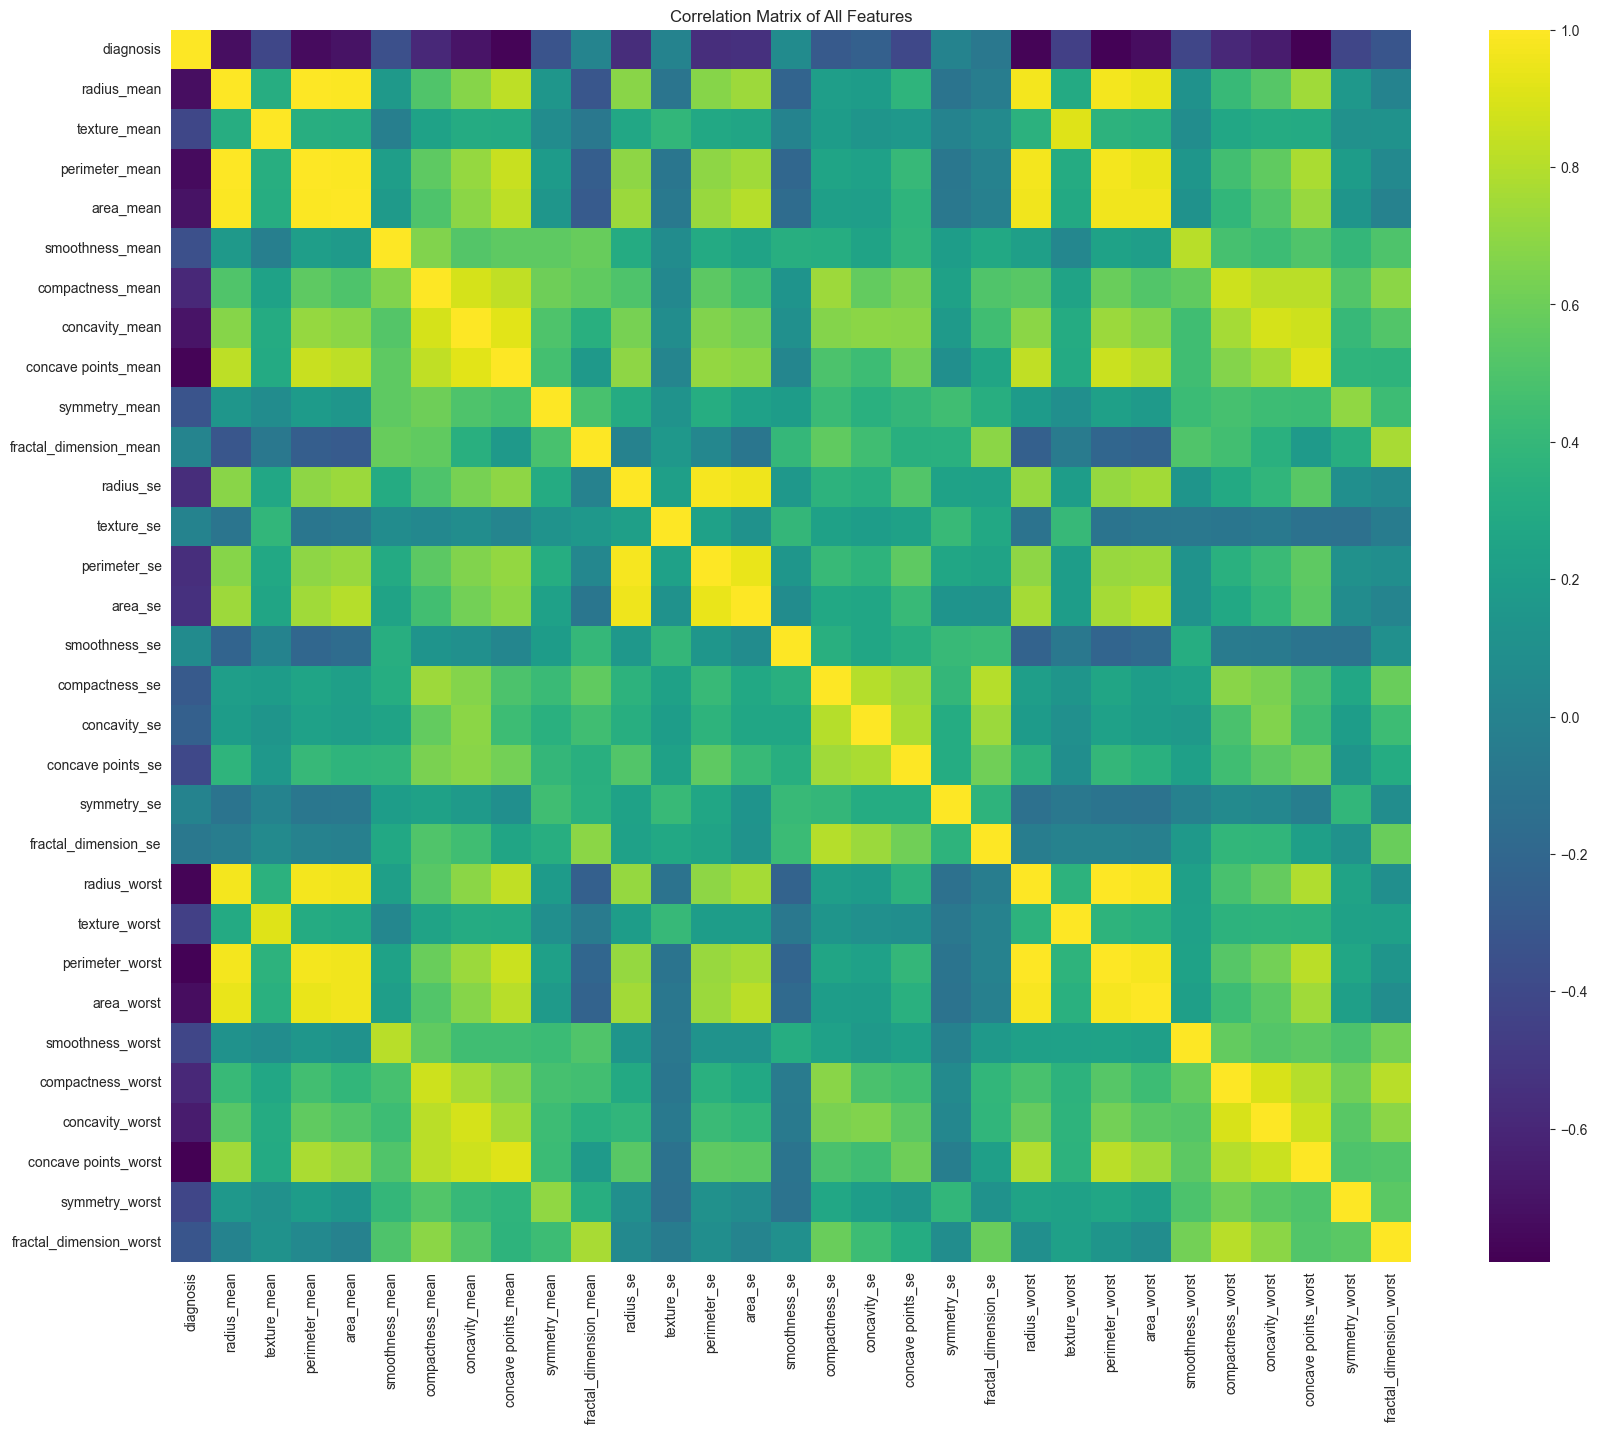

In [42]:
# Correlation Matrix
plt.figure(figsize=(20, 16))
sns.heatmap(df.corr(), annot=False, cmap='viridis')
plt.title('Correlation Matrix of All Features')
plt.show()

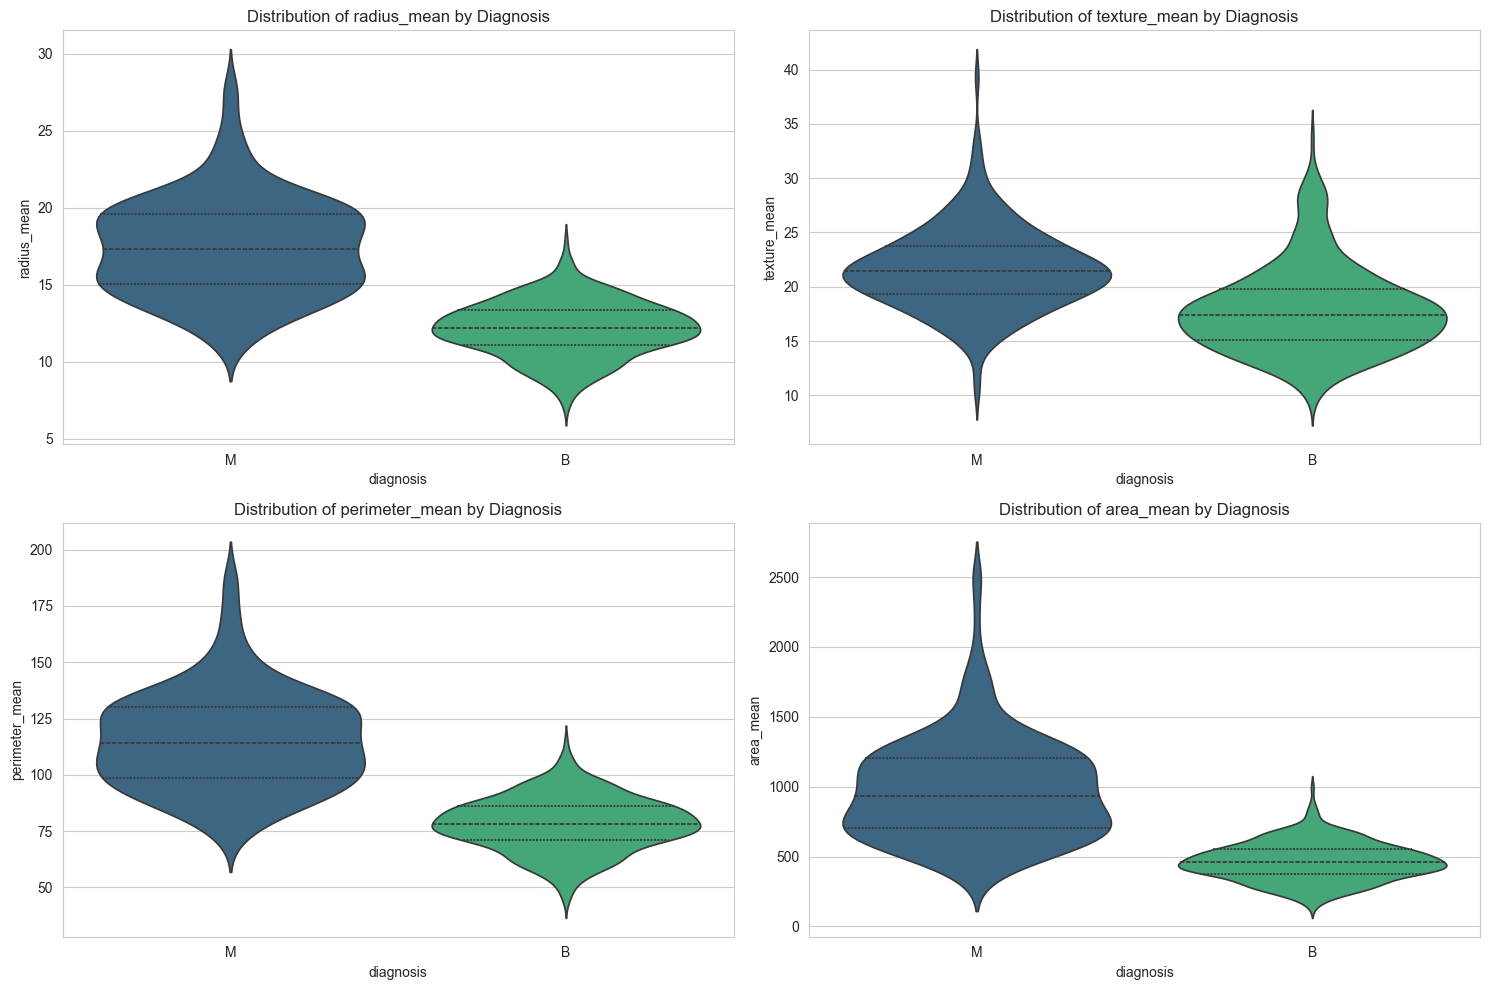

In [43]:
# Violin plots for distribution analysis
features_to_plot = ["radius_mean", "texture_mean", "perimeter_mean", "area_mean"]
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_to_plot):
    plt.subplot(2, 2, i+1)
    sns.violinplot(x='diagnosis', y=feature, data=df_viz, hue='diagnosis', palette='viridis', inner='quartile', legend=False)
    plt.title(f'Distribution of {feature} by Diagnosis')
plt.tight_layout()
plt.show()

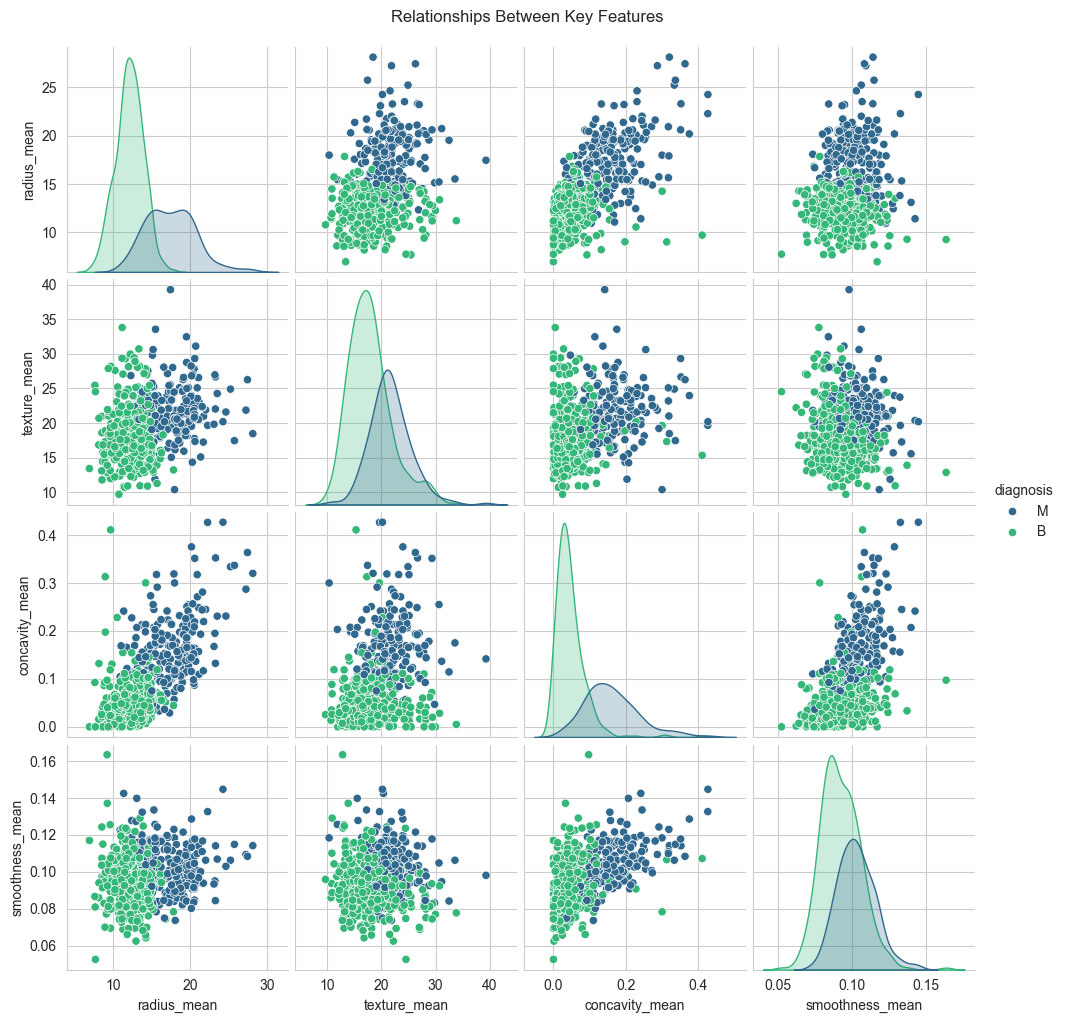

In [44]:
# Pairplot for visualizing relationships
pairplot_features = ['radius_mean', 'texture_mean', 'concavity_mean', 'smoothness_mean', 'diagnosis']
sns.pairplot(df_viz[pairplot_features], hue='diagnosis', palette='viridis')
plt.suptitle('Relationships Between Key Features', y=1.02)
plt.show()

## Preprocessing for Modeling

In [45]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Comparative Analysis of 7 Models

In [46]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVC": SVC(random_state=42),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss')
}

results = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred)
    })

results_df = pd.DataFrame(results).sort_values(by='F1-score', ascending=False).reset_index(drop=True)
print("Model Performance Comparison Table")
print(results_df)

Model Performance Comparison Table
                 Model  Accuracy  Precision    Recall  F1-score
0  Logistic Regression  0.986014   0.988889  0.988889  0.988889
1                  KNN  0.979021   0.967742  1.000000  0.983607
2                  SVC  0.979021   0.988764  0.977778  0.983240
3              XGBoost  0.965035   0.956989  0.988889  0.972678
4        Random Forest  0.958042   0.956522  0.977778  0.967033
5          Naive Bayes  0.937063   0.935484  0.966667  0.950820
6        Decision Tree  0.923077   0.954023  0.922222  0.937853


## Hyperparameter Tuning for the Best Model (Logistic Regression)

In [47]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# 'C' is the inverse of regularization strength (smaller C = stronger regularization)
# 'solver' is the algorithm used for optimization
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# We use f1 as the scoring metric because it is balanced.
grid_search = GridSearchCV(estimator=LogisticRegression(random_state=42),
                           param_grid=param_grid,
                           scoring='f1',
                           cv=kfold,
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_
print(f"\nBest parameters for Logistic Regression: {grid_search.best_params_}")
print(f"Best F1-score on cross-validation: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best parameters for Logistic Regression: {'C': 0.1, 'solver': 'liblinear'}
Best F1-score on cross-validation: 0.9850


## Final Evaluation of the Tuned Model

Classification Report for the Tuned Model
              precision    recall  f1-score   support

   Malignant       0.98      0.98      0.98        53
      Benign       0.99      0.99      0.99        90

    accuracy                           0.99       143
   macro avg       0.99      0.99      0.99       143
weighted avg       0.99      0.99      0.99       143



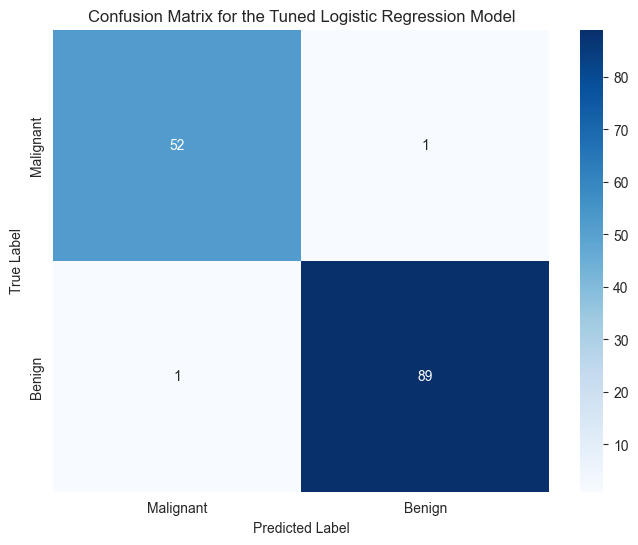

In [51]:
from sklearn.metrics import classification_report, confusion_matrix

# Final evaluation of the tuned model
y_pred_final = best_model.predict(X_test_scaled)

print("Classification Report for the Tuned Model")
print(classification_report(y_test, y_pred_final, target_names=['Malignant', 'Benign']))

# Confusion matrix for the best model
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Malignant', 'Benign'], yticklabels=['Malignant', 'Benign'])
plt.title('Confusion Matrix for the Tuned Logistic Regression Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Model Interpretation with SHAP

SHAP Feature Importance (Global Explanation)


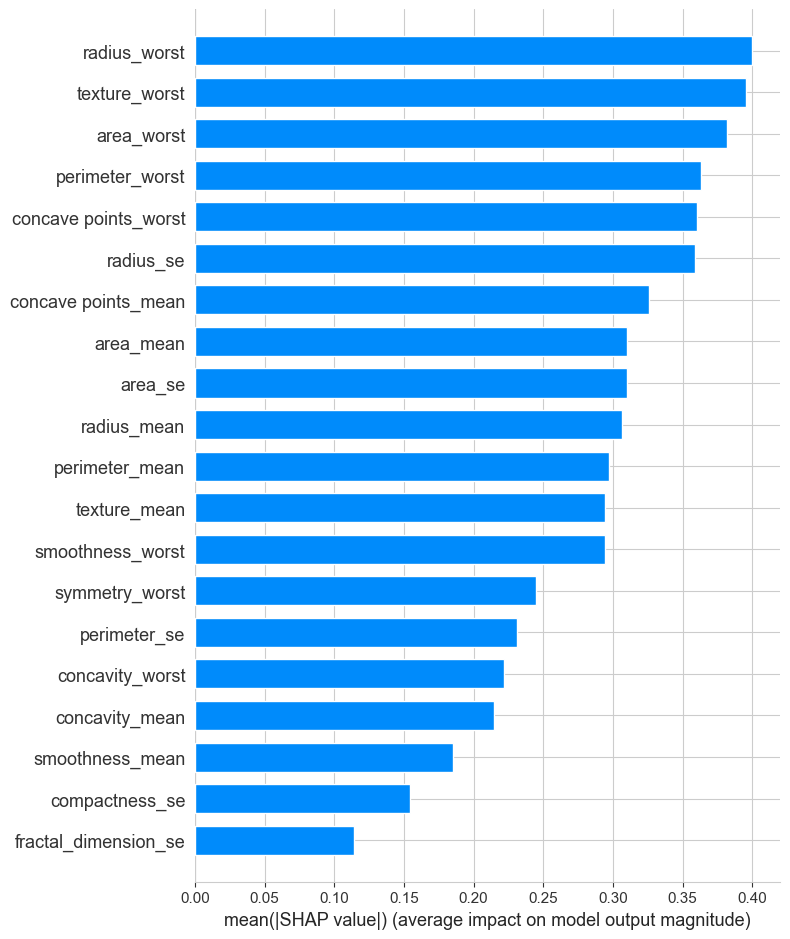

In [49]:
#Interpreting the Best Model (Logistic Regression) with SHAP

import shap

# For linear models, LinearExplainer is the most efficient
# It uses X_train_scaled to understand the baseline data distribution
explainer = shap.LinearExplainer(best_model, X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled)

# Global Explanation: Which features are the most important?
print("SHAP Feature Importance (Global Explanation)")

# This plot shows the average impact of each feature on the prediction
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns, plot_type="bar")

In [50]:
# Individual Prediction Explanation
# Let's take the first patient from the test set as an example

shap.initjs()

# This plot shows how features "pushed" the prediction one way or another
# base value - the average prediction across all data
# red features - increase the probability of malignancy
# blue features - decrease it
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])